<a href="https://colab.research.google.com/github/aripenguin/DATA620/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(513)

### Data Load and Analysis

The data we used is Food reviews from Amazon found on the Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/web-FineFoods.html). This dataset contains 568,454 food reviews for an array of products. Among the columns are the productId, userId, profileName (username), helpfulness, score, time, summary (review title), and text (review).

Since there are over 500,000 reviews, we will be taking a sample size of 15,000. For this assignment of graph visualization of nodes and edges, we will be focusing on some of the relationships of userIds and productIds as we are interested in, for example, which users reviewed which product. Therefore, we are using userId as nodes and productId as edges.


In [6]:
#Load Data
from google.colab import drive
drive.mount('/content/gdrive')
finefood = pd.read_csv('gdrive/My Drive/Colab Notebooks/Data 620/finefoods.csv')

#finefood = pd.read_csv('/Users/Lucas/Documents/CUNY/DATA620/finefoods.csv')
finefood = finefood.sample(n=15000, random_state=958)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


After loading and sampling the data, we create two new data frames from the perceptive of our nodes (userId) and edges (productId). These two hold every unique Id and summary values about each.

For userId, that includes each user's number of reviews, average helpfulness score, and average word count between all their reviews.

For ProductId, that includes each product's number of user reviews on it and the average score from these reviews.

After the creation of these two data frames, we found and included some stats.

In [7]:
finefood['word_count'] = finefood['text'].fillna('').apply(lambda x: len(x.split()))
finefood['helpful_num'] = finefood['helpfulness'].str.extract(r'(\d+)/')[0]
finefood['helpful_num'] = pd.to_numeric(finefood['helpful_num'], errors='coerce')

# Group by userId and compute columns
user_stats = finefood.groupby('userId').agg(
    review_count = ('userId', 'count'),
    avg_helpfulness = ('helpful_num', 'mean'),
    avg_word_count=('word_count', 'mean')
).reset_index()

user_stats = user_stats.sort_values(by='review_count', ascending=False)
user_stats['avg_helpfulness'] = user_stats['avg_helpfulness'].round(2)
user_stats['avg_word_count'] = user_stats['avg_word_count'].round(2)

# Group by productId and compute columns
product_stats = finefood.groupby('productId').agg(
    review_count = ('productId', 'count'),
    avg_score = ('score', 'mean')
).reset_index()

product_stats = product_stats.sort_values(by='review_count', ascending=False)
product_stats['avg_score'] = product_stats['avg_score'].round(2)

print(user_stats.head())
print(product_stats.head())

#stats
print("The number of unique users in sample of 15,000:", user_stats.shape[0])
print("The average number of reviews per userId:", round(user_stats['review_count'].sum() / user_stats.shape[0],4))
print("The average helpfulness score per userId:", round(user_stats['avg_helpfulness'].sum() / user_stats.shape[0],4))
print("The average word count per userId:", round(user_stats['avg_word_count'].sum() / user_stats.shape[0],4))

print("The number of unique products in sample of 15,000:", product_stats.shape[0])
print("The average number of reviews per productId:", round(product_stats['review_count'].sum() / product_stats.shape[0],4))
print("The average score per productId:", round(product_stats['avg_score'].sum() / product_stats.shape[0],4))

               userId  review_count  avg_helpfulness  avg_word_count
9698   A3OXHLG6DIBRW8            15             1.07          105.33
3451   A1YUL9PCJR3JTY            13             3.08          263.15
4602   A29JUMRL1US6YP            12             4.50          307.50
13490   AY12DBB0U420B            10             0.50          125.10
11439   ADS5APY1NKTL4             9             3.44           61.11
       productId  review_count  avg_score
8694  B007JFMH8M            27       4.52
5078  B001RVFERK            24       4.12
8532  B006N3HZ6K            21       4.24
5354  B0026RQTGE            21       4.00
2568  B000PDY3HI            19       4.00
The number of unique users in sample of 15,000: 13671
The average number of reviews per userId: 1.0972
The average helpfulness score per userId: 1.6577
The average word count per userId: 76.5518
The number of unique products in sample of 15,000: 9002
The average number of reviews per productId: 1.6663
The average score per productId

For notes, the average number of reviews per userId is really low. On the webpage for the original sized data frame, it is said that the number of users with > 50 reviews is only 260 so the chances of a bigger than one count is pretty low. This is also shown in the average number of review per productId that is less than 2.

Next, we created some graphs for data analysis.

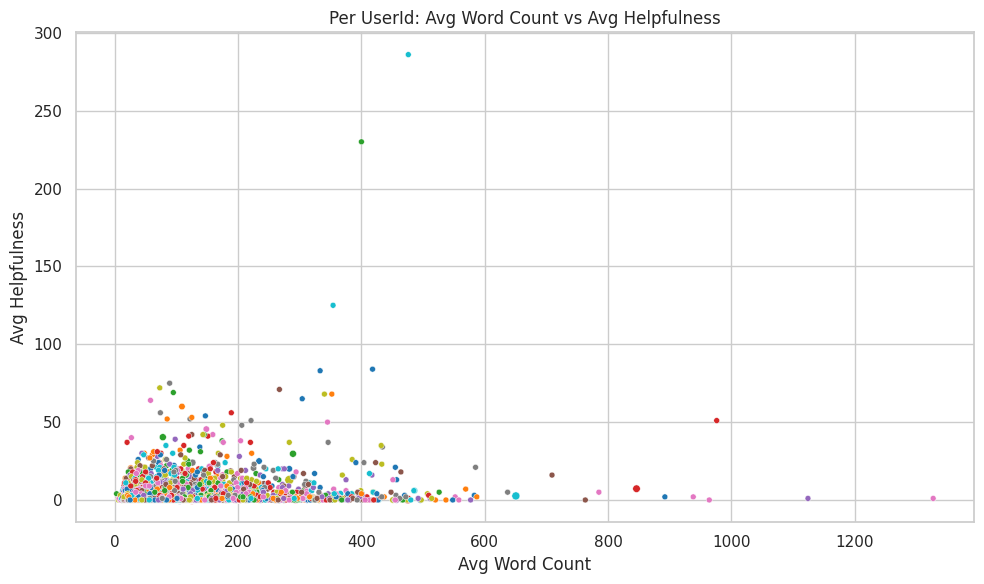

In [12]:
#graphs
top_users = user_stats.sort_values(by='review_count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=user_stats,
    x='avg_word_count',
    y='avg_helpfulness',
    size='review_count',
    hue='userId',
    legend=False,
    palette='tab10'
)

plt.title('Per UserId: Avg Word Count vs Avg Helpfulness')
plt.xlabel('Avg Word Count')
plt.ylabel('Avg Helpfulness')
plt.grid(True)
plt.tight_layout()
plt.show()

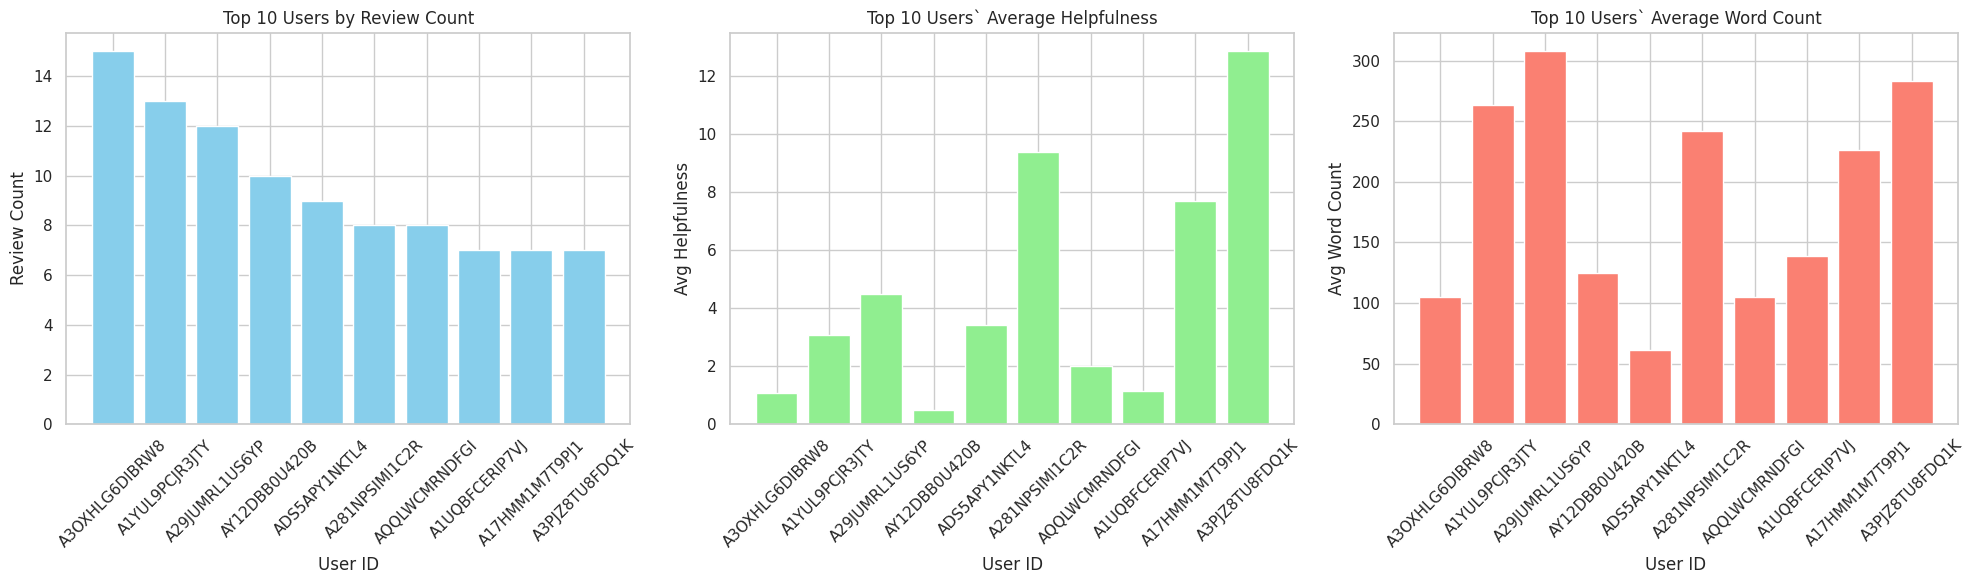

In [15]:
top_users = user_stats.sort_values(by='review_count', ascending=False).head(10)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Review Count
axes[0].bar(top_users['userId'], top_users['review_count'], color='skyblue')
axes[0].set_title('Top 10 Users by Review Count')
axes[0].set_xlabel('User ID')
axes[0].set_ylabel('Review Count')
axes[0].tick_params(axis='x', rotation=45)

# Avg Helpfulness
axes[1].bar(top_users['userId'], top_users['avg_helpfulness'], color='lightgreen')
axes[1].set_title('Top 10 Users` Average Helpfulness')
axes[1].set_xlabel('User ID')
axes[1].set_ylabel('Avg Helpfulness')
axes[1].tick_params(axis='x', rotation=45)

# Avg Word Count
axes[2].bar(top_users['userId'], top_users['avg_word_count'], color='salmon')
axes[2].set_title('Top 10 Users` Average Word Count')
axes[2].set_xlabel('User ID')
axes[2].set_ylabel('Avg Word Count')
axes[2].tick_params(axis='x', rotation=45)

# Tidy up layout
plt.tight_layout()
plt.show()

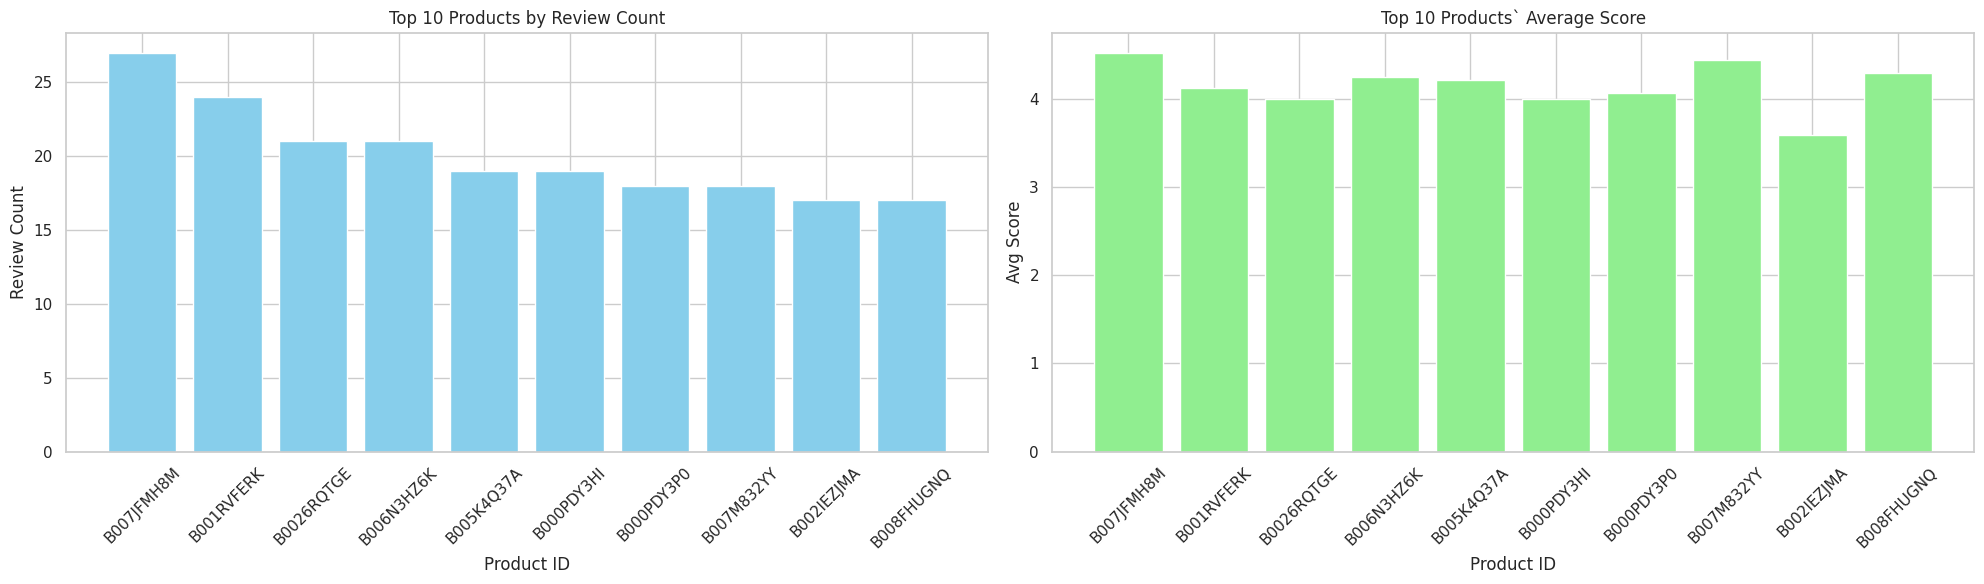

In [17]:
top_products = product_stats.sort_values(by='review_count', ascending=False).head(10)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Review Count
axes[0].bar(top_products['productId'], top_products['review_count'], color='skyblue')
axes[0].set_title('Top 10 Products by Review Count')
axes[0].set_xlabel('Product ID')
axes[0].set_ylabel('Review Count')
axes[0].tick_params(axis='x', rotation=45)

# Avg Score
axes[1].bar(top_products['productId'], top_products['avg_score'], color='lightgreen')
axes[1].set_title('Top 10 Products` Average Score')
axes[1].set_xlabel('Product ID')
axes[1].set_ylabel('Avg Score')
axes[1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

The scatter plot above shows that most users' reviews fall in the same area of short word counts or word counts not having a big effect on their helpfulness score. The few with bigger average helpfulness all have at least a 250 or higher average word count.

The bar plots are all focused on the top 10 users or products with the highest number of reviews recorded. Some interesting finds are that number of reviews has no effect on the user's average helpfulness or average word count as those plots are all over the place. In contract to products where all the top 10 products have really high and consistent average scores.

Interestingly, these products are all around a score of 4 with the highest being around 4.6. This may indicate that users are pretty harsh scorers not giving any 5s or the more reviews a product has, the more those reviews may be mixed.

### Graph creation

With the data frame loaded and analyized using pandas, now we can create the graph using networkx. In this case, we're firstly interested in which users reviewed which product. Therefore, we're using userId as nodes and productId as edges.


In [ ]:
foodnx = nx.from_pandas_edgelist(finefood, 'userId', 'productId')

### Graph connections

Because the graph is not fully connected, we need to pick a "cluster" of connected components to compute the diameter. For this, we can list the connected components, and in this case we're just going to pick the largest one.

In [3]:
#Check for full connection
is_connected = nx.is_connected(foodnx)
print(f'Graph connection: {is_connected}')

#Find all connected components
components = list(nx.connected_components(foodnx))

#Get the largest component
largest_component = max(components, key=len)
print(f'The largest component has {len(largest_component)} nodes.')

#Create a subgraph of the largest component
foodnx_sub = foodnx.subgraph(largest_component)

Graph connection: False
The largest component has 1590 nodes.


### Diameter

Next, we calculate the diameter of the largest component of 1,630 nodes.

In [4]:
#Analyze Diameter
diameter = nx.diameter(foodnx_sub)
print('Diameter:', diameter)

Diameter: 36


The Diameter is 51. This tell us that the longest ever walk we could do would be 51 nodes. Given that we have 1,630 nodes, this points to a relatively efficient graph, such as small-world networks. It is likely quite connected.

In order to increase our intuition about this graph, we can additionally look at the closeness centrality and look at the top connected nodes. This will tell us not only which users made the most reviews, but also how many.

In [5]:
#Analyze closeness centrality
clo_centrality = nx.closeness_centrality(foodnx_sub)
sorted_clo = sorted(clo_centrality.items(), key=lambda item: item[1], reverse=True)
print('Top 5 Nodes by Closeness Centrality:', sorted_clo[:5])

Top 5 Nodes by Closeness Centrality: [('B0058AMY74', 0.11844949683190459), ('ADS5APY1NKTL4', 0.1172953421421717), ('A3ARZW7S96SESC', 0.11297547102737292), ('B005VOOM5E', 0.11236829078565873), ('B0061IUIDY', 0.11220958971824024)]


The users and products above appear to be the most central players in the network.

Next, we can get an actual visualization of the network to understand how it actually looks like.

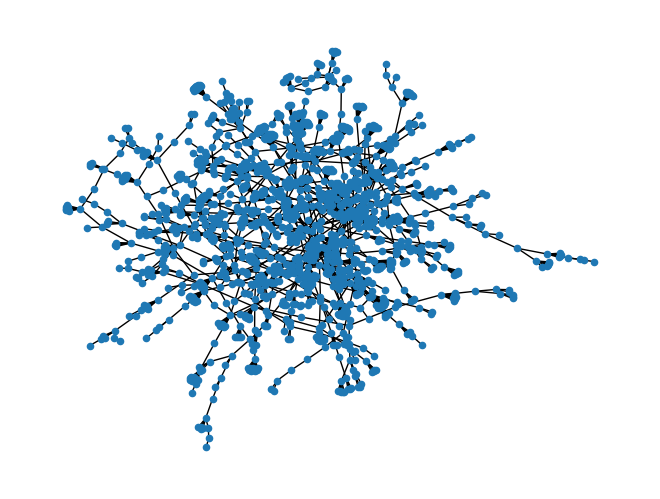

In [ ]:
#Draw the graph
nx.draw(foodnx_sub, node_size=20)

Looking at the visualization, we can see that there are several "branches" that are on the side, which potentially appear to be specific niches of fine foods that Amazon offers. Generally, the network is well connected, and does not appear to have a hub-and-spoke shape, for example.